In [2]:
# training
# A neural network implemented in PyTorch.
# At least one other Scikit-learn algorithm (for example, K-NN, SVM, Random Forest, Logistic Regression, etc.).
import pandas as pd
import numpy as np
from sklearn import neighbors
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords as sw
from unidecode import unidecode
import unicodedata
import re

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

In [3]:
# traindata = pd.read_csv('Datasets/PractiseData/development.csv', header=0)
traindata = pd.read_csv('Datasets/EvaluationData/politicES_phase_2_train_public.csv', header=0)

ytrain = traindata.iloc[:, :]
# print(ytrain)

## Exploratory Analysis of the Dataset

Before applying language processing techniques, a exploratory analysis of the dataset is performed. This analysis includes:
- General description: Number of instances, variables, data types, missing values
- Basic statistics and simple visualizations (class distribution, text lengths, etc.)
- Preliminary text analysis (most frequent words, word cloud, examples by class)
- Formulation of initial hypoteses about possible relationships between disinfomation and polarization.

### General description

In [4]:
# Shape of the training data
print("Training data shape:", ytrain.shape)

# Print the headers of the dataset
print("Headers:", ytrain.columns.tolist())

# Print the data types of each column
for col in ytrain.columns:
    first_non_null = ytrain[col].dropna().iloc[0] if not ytrain[col].dropna().empty else None
    padding = ' ' * (max(len(c) for c in ytrain.columns) - len(col))
    print(f"  Column '{col}' {padding} -> type: {type(first_non_null).__name__}")

# Users are in the first column, extract unique users from ytrain
unique_users = ytrain.iloc[:, 0].unique()
print("Unique users (labels) in training data:", len(unique_users))


Training data shape: (180000, 6)
Headers: ['label', 'gender', 'profession', 'ideology_binary', 'ideology_multiclass', 'tweet']
  Column 'label'                -> type: str
  Column 'gender'               -> type: str
  Column 'profession'           -> type: str
  Column 'ideology_binary'      -> type: str
  Column 'ideology_multiclass'  -> type: str
  Column 'tweet'                -> type: str
Unique users (labels) in training data: 2250


### Statics and simple visualizations

In [5]:
# Compute class distribution
class_counts = ytrain.iloc[:, 0].value_counts()
class_counts_unique = class_counts.nunique()

if class_counts_unique == 1:
    print("All classes have the same number of samples.")
    print(f"Each class has {class_counts.iloc[0]} samples.")
else:
    print("Class distribution in training data:")
    # Group consecutive classes with same count
    prev_count = None
    start_cls = None
    
    for cls, count in class_counts.items():
        if count != prev_count:
            if prev_count is not None:
                if start_cls == prev_cls:
                    print(f"  Classes {start_cls}: {prev_count} samples")
                else:
                    print(f"  Classes {start_cls} to {prev_cls}: {prev_count} samples")
            start_cls = cls
            prev_count = count
        prev_cls = cls
    
    # Print the last group
    if start_cls == prev_cls:
        print(f"  Classes {start_cls}: {prev_count} samples")
    else:
        print(f"  Classes {start_cls} to {prev_cls}: {prev_count} samples")

print(f"{'-' * 35}")

# Print text length statistics (from tweets column, which corresponds to the last column)
text_lengths = ytrain.iloc[:, -1].dropna().apply(len)
print("Text length statistics:")
print(f"  Minimum length: {text_lengths.min()}")
print(f"  Maximum length: {text_lengths.max()}")
print(f"  Average length: {text_lengths.mean():.2f}")
print(f"  Median length: {text_lengths.median()}")

All classes have the same number of samples.
Each class has 80 samples.
-----------------------------------
Text length statistics:
  Minimum length: 17
  Maximum length: 511
  Average length: 167.98
  Median length: 163.0


### Preliminary text analysis

In [ ]:
def preserve_letters(text: str, letters: list) -> str:
    # marca temporal para no perder la ñ/Ñ
    placeholders = {letter: f"__PLACEHOLDER_{i}__" for i, letter in enumerate(letters)}
    for k, v in placeholders.items():
        text = text.replace(k, v)
    # normalizar y quitar diacríticos
    text = unicodedata.normalize('NFKD', text)
    text = ''.join(ch for ch in text if not unicodedata.combining(ch))
    # restaurar placeholders a ñ/Ñ
    for k, v in placeholders.items():
        text = text.replace(v, k)
    return text

Most common words in tweets:
  'de': 291469 occurrences
  'la': 195468 occurrences
  'que': 167857 occurrences
  'el': 142782 occurrences
  'y': 142172 occurrences
  'en': 133463 occurrences
  'a': 123949 occurrences
  'los': 75496 occurrences
  'no': 65088 occurrences
  'es': 57876 occurrences
Most common words in tweets (cleaned):
  'hoy': 13298 occurrences
  'gobierno': 12072 occurrences
  'españa': 10346 occurrences
  'años': 8906 occurrences
  'gracias': 8494 occurrences
  'ser': 8321 occurrences
  'solo': 7588 occurrences
  'madrid': 6403 occurrences
  'tambien': 6359 occurrences
  'ley': 6304 occurrences


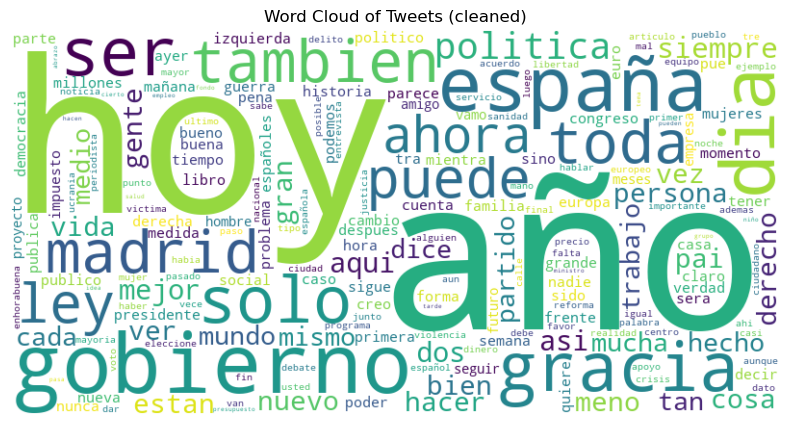

In [7]:
# Print most frequent words in the tweets, word cloud and examples by class
all_text = ' '.join(ytrain.iloc[:, -1].dropna().astype(str).tolist())
words = all_text.lower().split()
# Remove punctuation from words
tokens = preserve_letters(all_text.lower(), ['ñ', 'Ñ'])
# To remove anything but words (letters, numbers, and underscore)
words = re.findall(r"(?<!\S)[A-Za-z]\w*", tokens, flags=re.UNICODE)
# Get Spanish stopwords from nltk
spanish_sw = set(sw.words('spanish'))
extras = {'rt', 'https', 'http', 'jaja', 'jajaja', 'jajajaja', 'jajajajaja', 'mas', 'hace'}
stopwords = spanish_sw.union(extras)

clean_words = [w for w in words if len(w) > 2 and w not in stopwords]

word_counts = Counter(words)
most_common_words = word_counts.most_common(10)
print("Most common words in tweets:")
for word, count in most_common_words:
    print(f"  '{word}': {count} occurrences")


word_counts = Counter(clean_words)
most_common_words = word_counts.most_common(10)

print("Most common words in tweets (cleaned):")
for word, count in most_common_words:
    print(f"  '{word}': {count} occurrences")


wc_stopwords = STOPWORDS.union(stopwords)
clean_text = ' '.join(clean_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=wc_stopwords,
    collocations=False  # avoid duplicated bigrams like "new york"
).generate(clean_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets (cleaned)')
plt.show()

### Preliminary hypotheses

Although one might initially assume that disinformation mainly originates from more extreme or non‑moderate individuals, our analysis will explore whether this intuition is actually supported by the data.